In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed

2023 Refernece Data

In [6]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-04-18 05:00:00,29.6,0.42,10.5,0.0,28.0,39.0,86.0,23.6
2023-04-18 07:00:00,28.6,0.56,15.8,0.0,27.0,42.0,72.0,25.2
2023-04-18 09:00:00,30.1,0.74,25.9,1.2,36.0,49.0,63.0,27.9
2023-04-18 10:00:00,32.3,0.69,26.4,1.6,30.0,50.0,63.0,28.6


SGX Raw Data

In [7]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-04-18 03:00:00,-0.182333,11.906667,30.836000,93.887000
2023-04-18 04:00:00,-0.520000,10.272333,31.953000,93.873000
2023-04-18 05:00:00,-1.479667,10.057833,31.196500,93.984167


Target Gas

In [8]:
target_gas = 'CO'
additional_feature = []
all_feature = ['SGX-' + target_gas] + additional_feature
all_feature

['SGX-CO']

Data Division (Train, Validation, Test)

In [10]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index
train, test = np.split(dates, [int(.9*len(dates))])
print('Train size: {:d}, Test size: {:d}'.format(len(train), len(test)))

Train size: 1834, Test size: 204


In [11]:
x_train = pd.concat([sgx_data.loc[train, all_feature], ref_data.loc[train, ['REF-RH', 'REF-AMB_TEMP']]], axis=1)
x_test = pd.concat([sgx_data.loc[test, all_feature], ref_data.loc[test, ['REF-RH', 'REF-AMB_TEMP']]], axis=1)

y_train = ref_data.loc[train, [f'REF-{target_gas}']]
y_test = ref_data.loc[test, [f'REF-{target_gas}']]

Standardization

In [21]:
scaler = MinMaxScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

print('X-Train size: {}, X-Test size: {}'.format(x_train.shape, x_test.shape))
print('Y-Train size: {}, Y-Test size: {}'.format(y_train.shape, y_test.shape))

X-Train size: (1834, 3), X-Test size: (204, 3)
Y-Train size: (1834, 1), Y-Test size: (204, 1)


Model Selection

In [29]:
#################################################
model_type = 'SVR'
svr = SVR()
param = {'kernel' : ('linear', 'poly', 'rbf'),
         'C' : [0.1, 1, 5],
         'degree' : [2, 3, 5],
         'coef0' : [0.01, 0.5, 1],
         'gamma' : ('auto','scale')},
#################################################
# model_type = 'RF'
# rf = RandomForestRegressor()
# param = {
#     'n_estimators': [100, 300, 500, 700],
#     'max_depth': [1, 4, 8, 10],
#     'bootstrap': [True, False],
#     'min_samples_split': [2, 8, 16, 20]
#     }
#################################################
# model_type = 'xgb'
# xgb = XGBRegressor()
# param = {  'max_depth': [2, 3, 6, 10],
#            'learning_rate': [0.001, 0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.5, 0.7]}
#################################################
# model_type = 'mlp'
# regr = MLPRegressor()
# param = {  'hidden_layer_sizes': [[64], [128], [128, 128], [64, 128, 64]],
#            'alpha': [1e-5, 1e-4, 1e-3],
#            'learning_rate_init' : [1e-5, 1e-4, 1e-3],
#            'solver' : ['adam'],
#            'shuffle': [False],
#            'early_stopping': [True],
#            'random_state': [0]}
################################################
# model_type = 'lr'
# model = LinearRegression().fit(x_train,y_train.ravel())

grid_search = GridSearchCV(estimator = svr, param_grid = param, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train.ravel())

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=({'C': [0.1, 1, 5], 'coef0': [0.01, 0.5, 1],
                          'degree': [2, 3, 5], 'gamma': ('auto', 'scale'),
                          'kernel': ('linear', 'poly', 'rbf')},),
             verbose=2)

In [23]:
grid_search.best_params_

{'C': 5, 'coef0': 0.01, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}

In [30]:
model = grid_search.best_estimator_

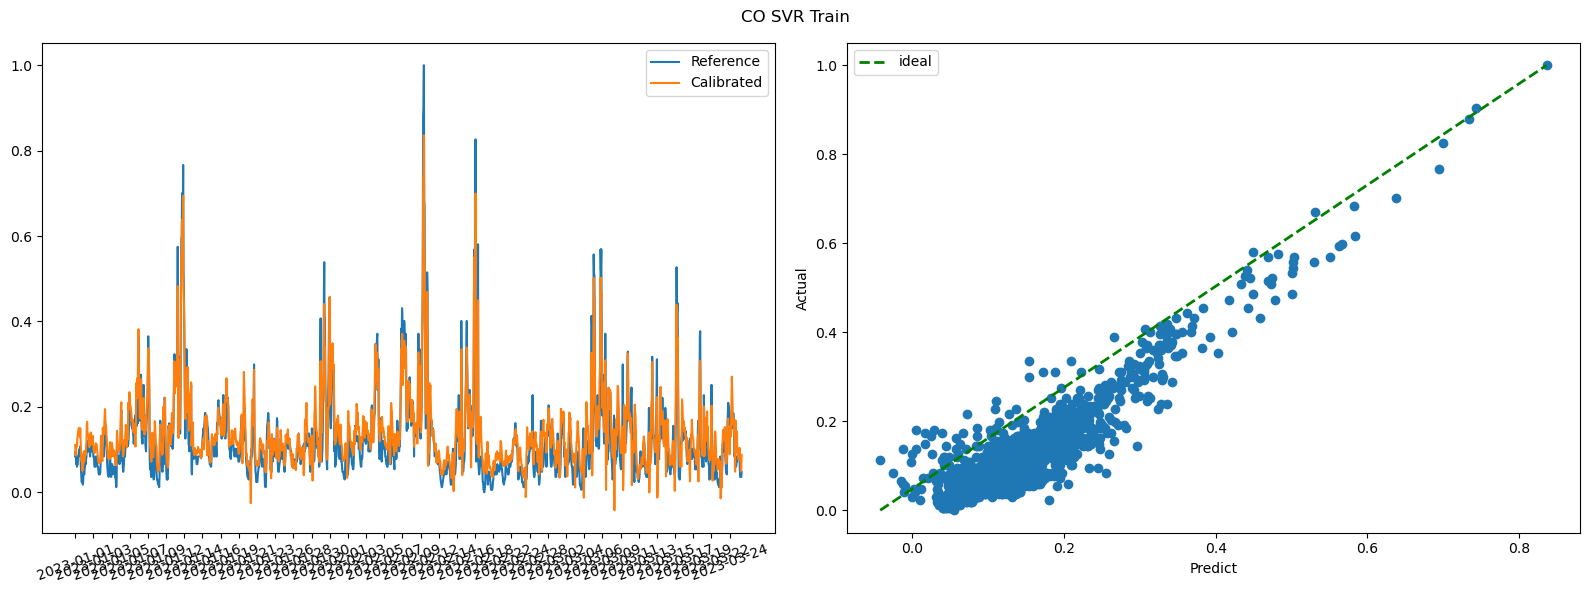

***R2 Score: 0.75
***RMSE: 0.0433


In [31]:
y_pred = model.predict(x_train)
visualize_result(y_train.ravel(), y_pred, train, f'{target_gas} {model_type} Train')
score(y_pred, y_train)

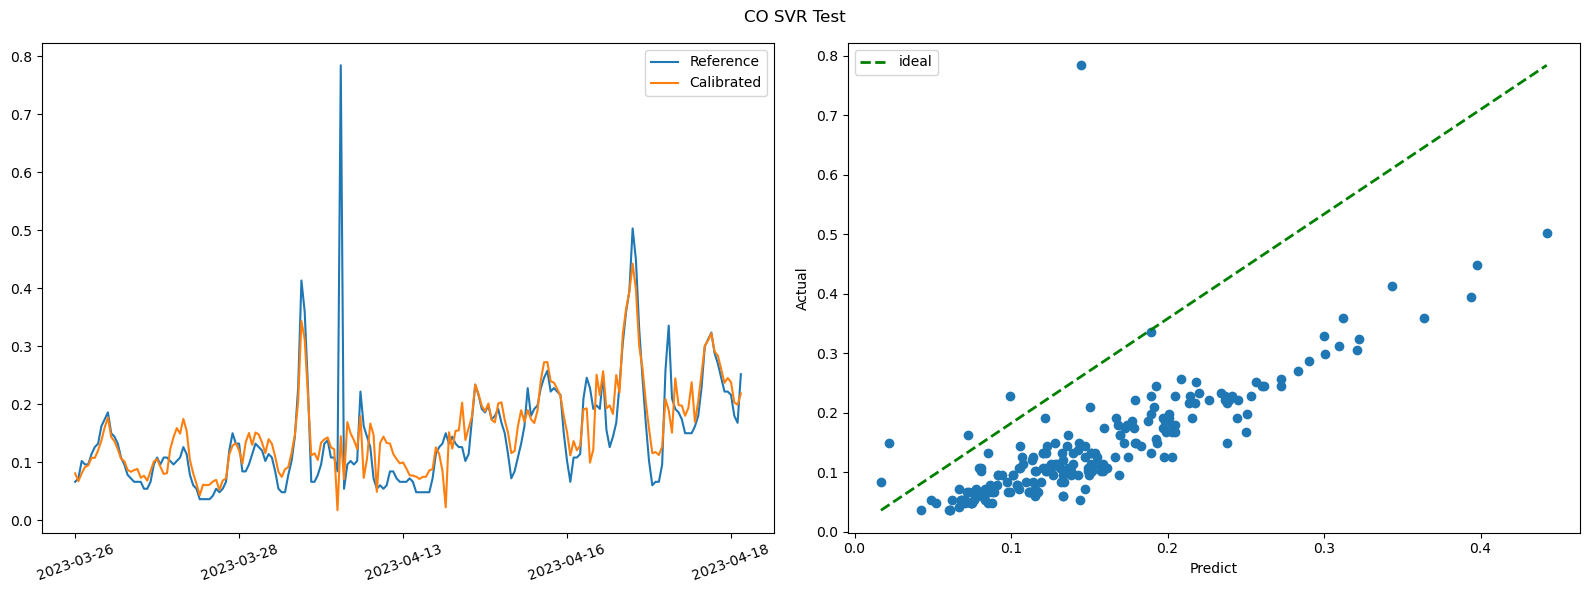

***R2 Score: 0.37
***RMSE: 0.0580


In [32]:
y_pred = model.predict(x_test)
visualize_result(y_test.ravel(), y_pred, test, f'{target_gas} {model_type} Test')
score(y_pred, y_test)

In [27]:
regr = LinearRegression()
regr.fit(sgx_data['SGX-NO2'].values.reshape(-1, 1), sgx_data['SGX-SO2'].values.reshape(-1, 1))
print(regr.coef_, regr.intercept_)
m = round(regr.coef_[0][0], 2)
b = round(regr.intercept_[0], 2)

[[4.16429998]] [19.06678441]


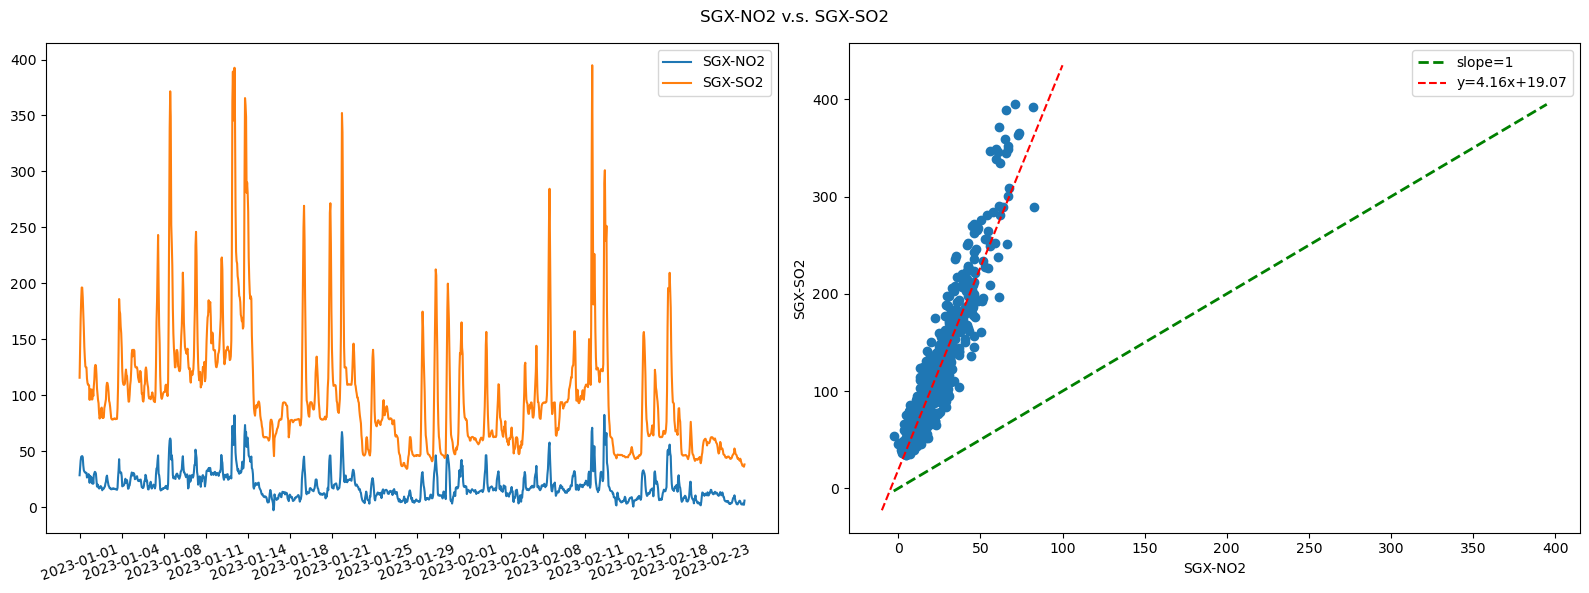

In [36]:


x = range(len(sgx_data.index.date))
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
fig.suptitle('SGX-NO2 v.s. SGX-SO2')
ax[0].plot(x, sgx_data['SGX-NO2'], label = 'SGX-NO2')
ax[0].plot(x, sgx_data['SGX-SO2'], label = 'SGX-SO2')
ax[0].set_xticks(np.arange(0, len(sgx_data.index), 80))
ax[0].set_xticklabels(labels = sgx_data.index[::80].date, rotation = 20)
ax[0].legend()
ax[1].scatter(sgx_data['SGX-NO2'], sgx_data['SGX-SO2'])
ax[1].plot([min(sgx_data['SGX-NO2']), max(sgx_data['SGX-SO2'])], [min(sgx_data['SGX-NO2']), max(sgx_data['SGX-SO2'])], 'g--', linewidth=2, markersize=12, label = 'slope=1')

x = np.linspace(-10, 100, 50)
y = m*x+b
plt.plot(x, y, 'r--', label=f'y={str(m)}x+{str(b)}')

ax[1].legend()
ax[1].set_xlabel('SGX-NO2')
ax[1].set_ylabel('SGX-SO2')
plt.tight_layout()
plt.savefig(f'fig/SGX_NO2_SO2_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()